# Data Exploratie notebook

# Index
- 1. [Phase 1: Business Understanding](#1-business-understanding)
- 2. [Phase 2: Data Understanding](#data-understanding)
    - 2.1 [2.1 Basis analyse](#basis-anaylyse)
    - 2.2 [Skewness](#skewness)
    - 2.3 [Grafieken](#grafieken)
    - 2.4 [Correlaties en Scatter Matrix](#correlaties-scatter)
- 3. [Phase 3: Data Preparation](#data-prep)
    - 3.1 [Afwijkingen uit fase 2 onderzoeken en oplossen](#afwijkingen)
    - 3.2 [Keys feature](#keys-feature)
    - 3.3 [Uitschieters detecteren](#uitschieters)
    - 3.4 [Feature Engineering](#feature-eng)

<a id="business-understanding"></a>
# Phase 1: Business Understanding

Het doel van dit model is om te testen of populariteit van een nummer 
<br>
voorspelt kan worden met lineaire regressie o.b.v de audio-features 
<br>
in deze dataset. 

<a id="data-understanding"></a>
# Phase 2: Data Understanding

Alle afwijkingen uit deze fase worden verder onderzocht in de derde fase. 

In [ ]:
# Modules importeren
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

In [ ]:
df = pd.read_csv("/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv") # Dataset importeren 

<a id="basis-anaylyse"></a>
## 2.1 Basis analyse

In [ ]:
display(df.head()) # eerste 5 rijen van de dataset weergeven

In [ ]:
df.shape # rijen en kolommen tellen
print(f"De dataset bevat {df.shape[0]} rijen en {df.shape[1]} kolommen.")

In [ ]:
df.info() # dtypes en null waarden bekijken

In [ ]:
df.describe().T # Statistiche informatie weergeven over numerieke kolommen

### Observatie statistische informatie
Time_signature minimum = 0, kan niet volgens spotify API
<br>
Tempo minimum = 0, kan eigenlijk niet 
<br>
Deze punten worden aangepakt in fase 3 
<br>
audio_valence = 0, danceability = 0. Kan, maar even checken 

### Dubbele waardes bekijken

In [ ]:
dubbel = pd.DataFrame({
    'Aantal dubbele waarden': [df[col].duplicated().sum() for col in df.columns],
    'Percentage dubbele waarden (%)': [
        round(df[col].duplicated().mean() * 100, 2) for col in df.columns
    ]
}, index=df.columns)
dubbel = dubbel.sort_values(by='Percentage dubbele waarden (%)', ascending=True)
print(dubbel)

### Observaties basis analyse 
Er zijn geen missende waardes. 
<br>
Alle features behalve song_name hebben numerieke waardes.
<br>
Er zijn veel dubbele waardes. Bij sommige kolommen is dit logisch (key, audio_mode, time_signature, song_popularity), bij anderen mogelijk onlogisch. 


## 2.2 Correlatie heatmap originele features

In [ ]:
df_num = df.select_dtypes(include=['number']).copy() # Dataframe maken met alleen numerieke kolommen

In [ ]:
corr = df_num.corr()

n = len(corr.columns)
scale = 0.7   # pas aan om de grootte van de vakjes te wijzigen
size = min(14, n * scale)

f, ax = plt.subplots(figsize=(size, size))

# Masker voor bovenste helft
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Tekstgrootte voor annotaties
annot_size = max(6, 14 - n // 2)

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.4,
    mask=mask,
    square=True,
    annot_kws={"size": annot_size},
    cbar_kws={"shrink": 0.6, "aspect": 30}  # <<< colorbar smaller maken
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('corrplot.png', dpi=600)
plt.show()

## 2.3 Distributies originele features 

In [ ]:
# Histogrammen van originele dataframe
df_num.hist(figsize=(15,12), bins=30)
plt.title("Distributie van numerieke featrures")
plt.tight_layout
plt.show()

### Observatie histogrammen originele df 
right skewed: song_duration_ms, acousticness, liveness, speechiness 
<br>
left skewed: danceability, tempo 
<br>
Discrete features: audio_mode, time_signature, key(cyclisch)
<br>
Continue features: alle andere features
<br>
Skewness komt overeen met skewness berekeningen

In [ ]:
# Plot popularity distribution
plt.hist(df["song_popularity"], bins=20, color="skyblue", edgecolor="black")
plt.title("Populariteit Distributie")
plt.xlabel("Popularity (0-100)")
plt.ylabel("Aantal songs")
plt.show()

### Observatie populariteit distributie
Piek tussen 50 en 75.

## 2.4 Feature Engineering

In [ ]:
def nieuwe_features(df):
    df = df.copy()
    df['valence_dance'] = df['audio_valence'] * df['danceability']
    
    # Ratio features
    df['acoustic_dance_ratio'] = df['acousticness'] / (df['danceability'] + 0.001)
    df['duration_energy_ratio'] = df['song_duration_ms'] / (df['energy'] + 0.001)
    
    return df

## 2.5 Distributies nieuwe features 

In [ ]:
df_num_features = nieuwe_features(df_num.copy())

new_cols = [c for c in df_num_features.columns if c not in df_num.columns]
print("New features added:\n", new_cols)

df_explore = df_num_features.copy()
df_explore['song_popularity'] = df['song_popularity']

df_num_features[new_cols].hist(figsize=(9,7), bins=30)
plt.suptitle("Histogrammen nieuwe features", fontsize=16)
plt.tight_layout()
plt.show()

### Observatie histogrammen nieuwe features
rechts-scheef: acoustic_dance_ratio en duration_energy_ratio

## Mutual information nieuwe features 

In [ ]:
from sklearn.feature_selection import mutual_info_regression
X = df_explore[new_cols]
y = df_explore['song_popularity']

mi_scores = mutual_info_regression(X, y, random_state=42)

mi_df = pd.DataFrame({'Feature': new_cols, 'Mutual Information': mi_scores})
mi_df.sort_values(by='Mutual Information', ascending=False, inplace=True)

print("\nMutual Information Scores (niet-lineaire feature relevantie):\n")
display(mi_df)

threshold = 0.02
selected_features = mi_df.loc[mi_df['Mutual Information'] > threshold, 'Feature'].tolist()

<a id="skewness"></a>
## 2.6 Skewness

https://samawat-ai.medium.com/skewness-and-kurtosis-c571fc4e0c0f

In [ ]:
from scipy.stats import skew 
from scipy.stats import kurtosis

In [ ]:
# Functie Skewness en kurtosis berekenen en highlighten van hoog scheef, matig scheef en redelijk symmetrisch 
def skewness_kurtosis(df):
    skewness = df.skew(numeric_only=True)
    kurtosis = df.kurt(numeric_only=True)

    stats_skew_kurt = pd.DataFrame({
        'skewness': skewness,
        'kurtosis': kurtosis
    })

    def highlighter(rij):
        skew = rij['skewness']
        color = ''
        if skew > 1 or skew < -1: # Hoge scheefheid (groter dan 1 of kleiner dan -1) kleur = rood 
            color = 'background-color: red; color: black;'
        elif 0.5 < abs(skew) <=1: # Matige scheefheid (scheefheid tussen -1 en -0.5 of tussen 0.5 en 1) kleur = blauw 
            color = 'background-color: #336df5; color: black;'
        elif abs(skew) <= 0.5: # Redelijk symmetrische distributie (scheefheid tussen -0.5 en 0.5) geen highlight
            color = 'color: white;'
        return ['' if c != 'skewness' else color for c in stats_skew_kurt.columns]
    
    styled = stats_skew_kurt.style.apply(highlighter, axis=1)
    display(styled)
    return stats_skew_kurt

In [ ]:
df_num = nieuwe_features(df_num)

### Skewness originele + engineered features

In [ ]:
stats = skewness_kurtosis(df_num)
skewed_cols = stats.loc[stats['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen:", skewed_cols)

### Observatie skewness originele en nieuwe features 
originele features: 'song_duration_ms', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'time_signature' zijn scheef verdeeld. 
<br>
rechts scheef: song_duration_ms, acousticness, liveness, speechiness -> log transformatie
<br>
links scheef : danceability, tempo -> yeo johnson transformatie 
<br>
nieuwe features: 'acoustic_dance_ratio' en 'duration_energy_ratio' zijn rechts scheef. -> log transformatie gebruiken 

In [ ]:
cat_cols = ['key', 'audio_mode', 'time_signature']
num_cols = df_num.drop(columns=cat_cols).columns

<a id="correlaties-scatter"></a>
## Correlaties en Scatter Matrix

## 2.7 Correlatie heatmap originele + engineered features 

0.00 – 0.30	nauwelijks of geen correlatie
<br>
0.30 – 0.50	lage of zwakke correlatie
<br>
0.50 – 0.70	middelmatige correlatie
<br>
0.70 – 0.90	hoge of sterke correlatie
<br>
0.90 – 1.00	zeer hoge of zeer sterke correlatie

In [ ]:
corr = df_num_features.corr()

# Schaal en figuurgrootte bepalen
n = len(corr.columns)
scale = 0.7
size = min(14, n * scale)
f, ax = plt.subplots(figsize=(size, size))  # gebruik size i.p.v. n*scale voor begrenzing

# Masker voor bovenste helft
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Lettergrootte aanpassen aan aantal kolommen
annot_size = max(6, 16 - n // 2)

# Heatmap tekenen
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.4,
    mask=mask,
    square=True,
    annot_kws={"size": annot_size},
    cbar_kws={"shrink": 0.6, "aspect": 30}  # <<< colorbar smaller maken
)

# Titel, assen en layout
plt.title("Correlatie heatmap met nieuwe features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

  danceability heeft de hoogste correlatie met song_popularity 
 <br>
 energy en acousticness hebben een redelijk sterke negatieve correlatie: -0.68
 <br>
 loudness en acousticness hebben een negatieve correlatie: -0.57 
 <br>
 loudness en instrumentalness hebben een negatieve correlatie: -0.4
 <br>
loudness en energy hebben een sterke positieve correlatie: 0.77

## 2.8 Scatter matrix 

In [ ]:
attributes = ['song_popularity', 'danceability', 'loudness', 'instrumentalness']
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

### Observatie correlatie heatmap en scatter matrices
De feature met de hoogste correlatie met song_popularity is danceability. 
<br>
Deze correlatie is 0.1. Erg laag 

<a id="data-prep"></a>
# Phase 3: Data Preparation

Afwijkingen fase 2 onderzoeken en data klaar maken voor training

#### Rijen waar zowel song_name als song_duration_ms dubbel zijn droppen 

In [ ]:
print(f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

# Dubbele waardes droppen van song_name en song_duration 
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration 
df.drop_duplicates(subset=['song_name', 'song_duration_ms'], inplace = True)
print(f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

In [ ]:
df_num_cleaned = df.select_dtypes(include=['number']).copy()

#### Time signature

In [ ]:
df_num_cleaned["time_signature"].value_counts()

time_signature gaat van 3 tot 7 volgens de Spotify API. 
<br>
Waardes van 1 en 0 zijn foute waardes. 

In [ ]:
# Indexen van time_signature == 0 
time_sig_is_zero = df_num_cleaned[df_num_cleaned['time_signature'] == 0]

# Indexen van time_signature == 1
time_sig_is_one = df_num_cleaned[df_num_cleaned['time_signature'] == 1]

# Dataframe maken van time_signatures 0 en 1 
df_time_signature_0_1 = pd.concat([time_sig_is_zero, time_sig_is_one])

# Statistische berekeningen zien van waardes met time signatures van 0 en 1 
display(df_time_signature_0_1.describe()) 

Omdat meerdere waardes afwijken: tempo, audio_valence, time_signature, speechiness, instrumentalness, danceability en song_popularity hebben allemaal een minimum van 0.0.
<br>
Bij sommige features zou een minimum van 0.0 theoretisch kunnen, maar de kans dat tempo een 0.0 minimum heeft kan bijvoorbeeld eigenlijk niet, want een liedje kan niet geen tempo hebben. 
<br>
Omdat er in totaal maar 66 rijen zijn met een time_signature van 1 of 0, heb ik ervoor gekozen om deze rijen allemaal te droppen. 

In [ ]:
df = df[df['time_signature'] > 1]
df_num = df_num[df_num['time_signature'] > 1]
df_num_cleaned = df_num_cleaned[df_num_cleaned['time_signature'] > 1]

#### Tempo 

In [ ]:
# Nummers met een tempo van 0. 
nul_tempo = df_num_cleaned.loc[df_num_cleaned['tempo'] == 0, ['tempo', 'song_popularity']]
print(f'Nummers met een tempo van 0: {nul_tempo}')

# Tempo == 0 is opgelost na verwijderen nummers

#### Danceability 

In [ ]:
df_num_cleaned['danceability'].value_counts()

<a id="keys-feature"></a>
### Keys feature

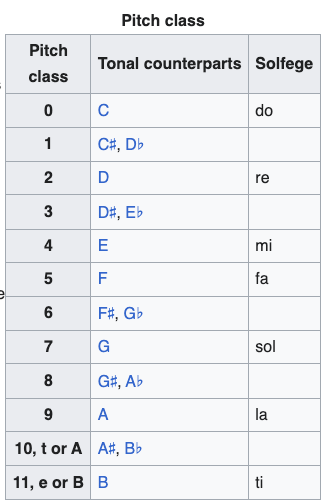

Dit is circulair: 12 en 0 zijn dezelfde toonsoort. 

0 (C) en 11 (B)  liggen numeriek ver uit elkaar, maar muzikaal liggen ze recht naast elkaar 


https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

https://medium.com/@axelazara6/why-we-need-encoding-cyclical-features-79ecc3531232

In [ ]:
# Plotten van key met sample van de eerste 60 data 
sample = df_num_cleaned[:60]
ax = sample['key'].plot()

In [ ]:
# Handmatig cyclisch encoden 
df_num_cleaned['key_sin'] = np.sin(2*np.pi*df['key']/12)
df_num_cleaned['key_cos'] = np.cos(2*np.pi*df['key']/12)

In [ ]:
# Plotten van key met eerste 60 data na cyclisch encoden. 
sample = df_num_cleaned[:60]
ax = sample['key_sin'].plot()

De schaal is veranderd naar -1 tot +1 

In [ ]:
# Plot twee dimensioneel perspectief 
ax = df_num_cleaned.plot.scatter('key_sin', 'key_cos').set_aspect('equal')

<a id="uitschieters"></a>
## Uitschieters detecteren en verwijderen

In [ ]:
def uitschieters(df):
    """ Markeert uitschieters."""

    df = df.copy()
    df_outliers = pd.DataFrame(index=df.index)

    # song_duration_ms — <30 sec of >20 min (vind ik te onwaarschijnlijk dat het dan een liedje is)
    df_outliers['song_duration_ms'] = (
        (df['song_duration_ms'] < 30_000) | 
        (df['song_duration_ms'] > 1_200_000)
    )

    # tempo — 30–250 BPM (o.b.v https://en.wikipedia.org/wiki/Tempo))
    df_outliers['tempo'] = (df['tempo'] < 30) | (df['tempo'] > 250)

    # loudness — normaal tussen -60 en 0 dB
    df_outliers['loudness'] = (df['loudness'] < -60) | (df['loudness'] > 0)

    # features met een range van 0-1 volgens Spotify API
    for col in ['danceability', 'energy', 'audio_valence', 'instrumentalness', 'liveness', 'speechiness']:
        if col in df.columns:
            df_outliers[col] = (df[col] < 0) | (df[col] > 1)

    # time_signature — meestal 3, 4 of 5
    if 'time_signature' in df.columns:
        df_outliers['time_signature'] = ~df['time_signature'].isin([3, 4, 5])

    # Samenvattende indicator: True als een rij minstens één outlier heeft
    df['is_uitschieter'] = df_outliers.any(axis=1)

    return df, df_outliers

In [ ]:
df_num_cleaned, df_outliers = uitschieters(df)
outlier_telling = df_outliers.sum().sort_values(ascending=False)
print(outlier_telling)

In [ ]:
aantal_verwijderd = df_num_cleaned['is_uitschieter'].sum()
percentage_verwijderd = df_num_cleaned['is_uitschieter'].mean() * 100

In [ ]:
df_num_cleaned = df_num_cleaned[~df_num_cleaned['is_uitschieter']].copy()

In [ ]:
print(f"Verwijderd: {aantal_verwijderd} rijen ({percentage_verwijderd:.2f}%)")

In [ ]:
# is_uitschieter kolom verwijderen na cleaning
df_num_cleaned = df_num_cleaned.drop(columns='is_uitschieter')

<a id="feature-eng"></a>
### Feature Engineering

### Scaling

Log-transformatie: song_duration_ms, acousticness, liveness, speechiness, acoustic_dance_ratio en duration_energy_ratio 
<br>
Yeo-johnson: danceability, tempo

### Log transformation

In [ ]:
stats = skewness_kurtosis(df_num_cleaned)
skewed_cols = stats.loc[stats['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen:", skewed_cols)

In [ ]:
log_cols = ['song_duration_ms', 'acousticness', 'liveness', 'speechiness', 'acoustic_dance_ratio', 'duration_energy_ratio']

# Kleine constante toevoegen om log(0) te vermijden
df_log = df_num_cleaned.copy()
for col in log_cols:
    df_log[col + '_log'] = np.log1p(df_log[col])  # log1p = log(1 + x)

### Yeo-Johnson transformation

In [ ]:
yeo_cols = ['danceability', 'audio_valence', 'energy', ]
df_yeo = df_num_cleaned[yeo_cols]

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
transformed_data_yeo = pt.fit_transform(df_yeo)
transformed_df_yeo = pd.DataFrame(transformed_data_yeo, columns = df_yeo.columns, index=df_yeo.index)

In [ ]:
scaler = StandardScaler()
scaled_data_yeo = scaler.fit_transform(transformed_df_yeo)
scaled_df_yeo = pd.DataFrame(scaled_data_yeo, columns=transformed_df_yeo.columns, index=transformed_df_yeo.index)

In [ ]:
# Skewness en kurtosis van df_num_cleaned vóór Power transformatie 
org_cols = ['danceability', 'audio_valence', 'energy']
stats_origineel = skewness_kurtosis(df_num_cleaned[org_cols])
skewed_cols = stats.loc[stats['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen:", skewed_cols)

In [ ]:
# Skewness en kurtosis van df na yeo johnson transformatie 
stats_transformed = skewness_kurtosis(transformed_df_yeo)
skewed_cols = stats.loc[stats['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen:", skewed_cols)

Niet meer skewed na yeo johnson transformatie

In [ ]:
# Transformed + Scaled data histogrammen 
cols = df_yeo.columns
n_cols = 3  # how many plots per row
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

for i, col in enumerate(cols):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]

    # Plot original
    ax.hist(df_num_cleaned[col], bins=30, alpha=0.5, label='Original')
    # Plot transformed
    ax.hist(scaled_df_yeo[col], bins=30, alpha=0.5, label='Transformed+scaled')

    ax.set_title(col)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    r, c = divmod(j, n_cols)
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()

dancability, energy, audio valence en mogelijk loudnesss worden beter van yeo johnson transformatie, de rest niet. 